In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI

In [3]:
import os 
from langchain_core.tools import tool
from graphrag import GraphStoreRetriever
from utils import merge_spaces
from constant import *

graph_retriever = GraphStoreRetriever.from_neo4j(db_url=os.getenv("NEO4J_URI"), \
                                                db_username=os.getenv("NEO4J_USERNAME"), \
                                                db_password=os.getenv("NEO4J_PASSWORD"), \
                                                openai_embed_model="text-embedding-3-large")
@tool
def search_tour(query: str) -> str:
    """Consulting on the tour that best suits the user's needs.
    
    Args:
        query (str): Description of the tour that the user wants.

    Returns:
        str: List of tours suitable to user needs.
    """
    tours = graph_retriever.query(query)
    contexts = ""
    for i, r in enumerate(tours):
        contexts += f"Tour {i}: \n{r['p']['name']} \n{merge_spaces(r['p']['info'])} \nChi phí cho mỗi người: {r['p']['price_per_person']} \n{r['p']['description']} \n\n"
    return contexts

In [4]:
@tool
def connect_tour_sales_staff(query: str) -> str:
    """Assign a sales person to assist customers with booking tours, negotiating, and resolving queries.
    
    Args:
        query (str): Customer's desire for a specific tour. For example: want to reduce tour price.

    Returns:
        str: List of tours suitable to user needs.
    """
    return "Connecting to a sales person. Please reply to the user and wait a moment."

In [5]:
from langchain_core.runnables import ensure_config

@tool
def fetch_user_information() -> dict:
    """Get user information.

    Returns:
        Dictionary containing detailed information about the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None) 
    if not user_id:
        raise ValueError("No user ID configured.")
    return {
        "user_id": user_id,
        "user_name": configuration.get("user_name"),
        "user_phone_number": configuration.get("user_phone_number")
    }


## Utilities
Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [6]:

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

## State
Define our StateGraph's state as a typed dictionary containing an append-only list of messages. These messages form the chat history, which is all the state our simple assistant needs.

In [7]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "primary_assistant",
                "tour_consultant",
                "tour_sales_manager",
            ]
        ],
        update_dialog_stack,
    ]

## Agent
Next, define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [8]:
from typing import Any
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.pydantic_v1 import BaseModel, Field
from datetime import datetime
from langchain_community.tools.tavily_search import TavilySearchResults

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}
    
class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the tour for more information.",
            },
        }

llm = ChatOpenAI(model="gpt-4o-mini")

tour_consultant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a highly knowledgeable and friendly travel consultant chatbot. "
            "Your goal is to assist customers in finding the perfect tour for their needs. " 
            "You should ask detailed questions to understand their preferences and requirements, suggest suitable tours, provide additional information about destinations, activities, and travel logistics, and ensure a seamless customer experience. "
            "Always be polite, enthusiastic, and responsive to their needs. " 
            "Your knowledge includes a wide range of destinations, activities, travel tips, and budget-friendly options."
            "\n\nCurrent user information:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
tour_consultant_tools = [search_tour]
tour_consultant_runnable = tour_consultant_prompt | llm.bind_tools(
    tour_consultant_tools + [CompleteOrEscalate]
)


tour_sale_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a proficient and personable travel tour sales manager. " 
            "Your job is to assign the right sales person to advise the customer in booking the perfect tour, negotiating tour prices, applying promotional offers, and adjusting tour designs to meet budget requirements. " 
            "Ensure a smooth booking process and a positive customer experience by being polite, enthusiastic, and responsive to their needs. " 
            "\n\nCurrent user information:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
tour_sale_tools = [connect_tour_sales_staff]
tour_sale_runnable = tour_sale_prompt | llm.bind_tools(
    tour_sale_tools + [CompleteOrEscalate]
)
    
# Primary Assistant
class ToTourConsultantAssistant(BaseModel):
    """Transfers work to highly knowledgeable and friendly travel consultant assistant to assisting customers in finding the perfect tour"""

    query: str = Field(
        description="User's message"
    )


class ToTourSaleAssistant(BaseModel):
    """
    Transfers work to proficient and personable travel tour sales specialist to assisting customers in booking the perfect tour
    Key tasks:
    - Negotiate tour prices with customers, apply promotional policies, and adjust tour designs to match the customer's budget. 
    - Present and explain additional services that customers can purchase to enhance their tour experience. 
    - Assist customers through the tour booking process, ensuring all their needs and preferences are met. 
    """

    query: str = Field(
        description="Customer's desire for a specific tour. For example: want to reduce tour price."
    )


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant of DAC-Travel."
            "Your main role is to look up tour information and company policies to answer customers' questions."
            "If a customer requests to change the tour price or change the tour design, tour amenities or upgrade the room class, etc., "
            "assign the task to the appropriate sales specialist using the corresponding tool. You cannot make these changes yourself."
            "Only sales specialists are authorized to do this for users."
            "If a customer requests to book a tour, tactfully invite them to leave their phone number so that the sales staff can call them directly to support them."
            "Users do not know about the different professional assistants, so do not mention them; just quietly assign tasks through function calls."
            "Provide detailed information to customers and always double-check the database before concluding that information is unavailable."
            "When searching, be persistent. Expand your query if your first search does not return any results."
            "If your search does not return any results, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# primary_assistant_tools = [TavilySearchResults(max_results=1)]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    [
        ToTourConsultantAssistant,
        ToTourSaleAssistant, 
    ]
)

## Create Assistant
We're about ready to create the graph. In the previous section, we made the design decision to have a shared messages state between all the nodes. This is powerful in that each delegated assistant can see the entire user journey and have a shared context. This, however, means that weaker LLMs can easily get mixed up about there specific scope. To mark the "handoff" between the primary assistant and one of the delegated workflows (and complete the tool call from the router), we will add a ToolMessage to the state.

## Utility
Create a function to make an "entry" node for each workflow, stating "the current assistant is assistant_name".

In [9]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the search tour, order tour, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

## Define Graph 
Now, create the graph. The graph is the final assistant for this section.

In [10]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

def user_info(state: State) -> dict:
    return {"user_info": fetch_user_information.invoke({})}

builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

### Agent assistant

In [11]:
# Tour consultant assistant -----------------------------------------------------------------
builder.add_node(
    "enter_tour_consultant",
    create_entry_node("Tour Consultant Assistant", "tour_consultant"),
)
builder.add_node("tour_consultant", Assistant(tour_consultant_runnable))
builder.add_edge("enter_tour_consultant", "tour_consultant")

builder.add_node(
    "tour_consultant_tools",
    create_tool_node_with_fallback(tour_consultant_tools),
)

def route_tour_consultant(
    state: State,
) -> Literal[
    "tour_consultant_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        print("route_tour_consultant: END")
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        print("route_tour_consultant: leave_skill")
        return "leave_skill"
    toolnames = [t.name for t in tour_consultant_tools]
    if all(tc["name"] in toolnames for tc in tool_calls):
        return "tour_consultant_tools"
    
builder.add_edge("tour_consultant_tools", "tour_consultant")
builder.add_conditional_edges("tour_consultant", route_tour_consultant)


# Tour sale assistant ------------------------------------------------------------------------
builder.add_node(
    "enter_tour_sale",
    create_entry_node("Tour Sale Assistant", "tour_sales_manager"),
)
builder.add_node("tour_sales_manager", Assistant(tour_sale_runnable))
builder.add_edge("enter_tour_sale", "tour_sales_manager")

builder.add_node(
    "tour_sale_tools",
    create_tool_node_with_fallback(tour_sale_tools),
)

def route_tour_sale(
    state: State,
) -> Literal[
    "tour_sale_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    toolnames = [t.name for t in tour_sale_tools]
    if all(tc["name"] in toolnames for tc in tool_calls):
        return "tour_sale_tools"
    
builder.add_edge("tour_sale_tools", "tour_sales_manager")
builder.add_conditional_edges("tour_sales_manager", route_tour_sale)

# This node will be shared for exiting all specialized assistants ------------------------------------------------
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }

builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

### Primary assistant

In [12]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))

def route_primary_assistant(
    state: State,
) -> Literal[
    "enter_tour_consultant",
    "enter_tour_sale",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToTourConsultantAssistant.__name__:
            return "enter_tour_consultant"
        elif tool_calls[0]["name"] == ToTourSaleAssistant.__name__:
            return "enter_tour_sale"
    raise ValueError("Invalid route")

# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_tour_consultant": "enter_tour_consultant",
        "enter_tour_sale": "enter_tour_sale",
        END: END,
    },
)
# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "tour_consultant",
    "tour_sales_manager",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

builder.add_conditional_edges("fetch_user_info", route_to_workflow)

In [13]:
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = AsyncSqliteSaver.from_conn_string(":memory:")

graph = builder.compile(
    checkpointer=memory,
)

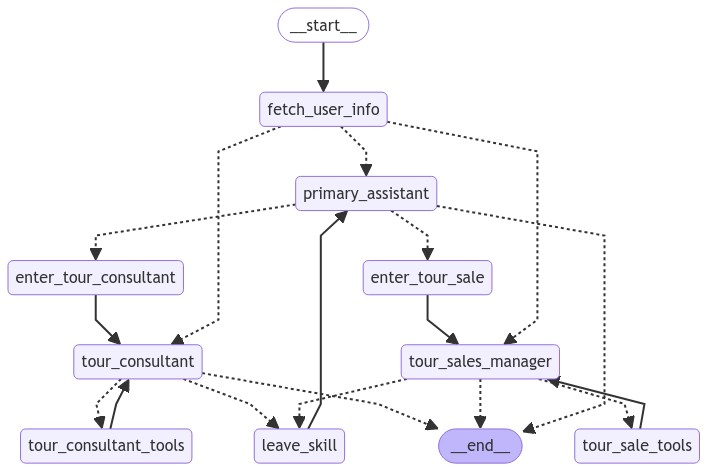

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Example Conversation

In [15]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "user_id": "3442587242",
        "user_name": "Duc Anh",
        "user_phone_number": "0835238749",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

In [16]:
tutorial_questions = [
    "Xin chào, ban co tour nao đi Đà Nẵng k?",
    "toi muon thương lượng giá tour",
]

import asyncio
async def async_input(prompt):
    # A coroutine that uses an executor to handle synchronous input asynchronously
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, input, prompt)

_printed = set()
for question in tutorial_questions:
    async for event in graph.astream_events(
        {"messages": ("user", question)}, config, stream_mode="values", version="v1"
    ):
        if event["event"] == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
                print(content, end="|")
        elif event["event"] == "on_tool_start" or event["event"] == "on_tool_end": # TODO: Disable on production
            print(event['name'], "\n", event["data"])

/home/anhcd/miniconda3/envs/langgraph/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


fetch_user_information 
 {'input': {}}
fetch_user_information 
 {'input': {}, 'output': {'user_id': '3442587242', 'user_name': 'Duc Anh', 'user_phone_number': '0835238749'}}
search_tour 
 {'input': {'query': 'tour Đà Nẵng'}}
search_tour 
 {'input': {'query': 'tour Đà Nẵng'}, 'output': None}
Xin| ch|ào|!| Hi|ện| tại| tôi| không| thể| tìm| thấy| thông| tin| về| tour| đi| Đ|à| N|ẵ|ng|.| Tuy| nhiên|,| tôi| có| thể| giúp| bạn| liên| hệ| với| nhân| viên| bán| tour| để| tìm| hiểu| thêm| về| các| tour| này|.| Bạn| có| thể| để| lại| số| điện| thoại| của| mình| để| nhân| viên| có| thể| gọi| lại| hỗ| trợ| bạn| không|?|fetch_user_information 
 {'input': {}}
fetch_user_information 
 {'input': {}, 'output': {'user_id': '3442587242', 'user_name': 'Duc Anh', 'user_phone_number': '0835238749'}}
connect_tour_sales_staff 
 {'input': {'query': 'Thương lượng giá tour đi Đà Nẵng'}}
connect_tour_sales_staff 
 {'input': {'query': 'Thương lượng giá tour đi Đà Nẵng'}, 'output': ToolMessage(content='Connecting t